In [1]:
# Plotting script for results
import os
import matplotlib.pyplot as plt
from read_results_helpers import *

In [2]:
total_hours = 8784
# Plotting results for cost and capacity
def plot_results(results_dir, color_dict, poi, outfile_suffix = '', pass_results=[]):
    all_results = []
    max_result = 0
    fig, ax = plt.subplots(figsize=(10, 5))
    # Increase white space left and bottom
    fig.subplots_adjust(left=0.85, bottom=0.6)

    files = [f for f in os.listdir(results_dir) if f.endswith('.pickle')]
    files.pop(files.index('all_firm_all.pickle'))
    files_sorted = sorted(files, key=lambda x: int(x.split('_')[3]))
    files_sorted.insert(0, 'all_firm_all.pickle')

    # Loop over all case pickle files in all_firm_case folder
    for i,case_file in enumerate(files_sorted):

        if i==0 or len([x for x in results.values() if x != 0]) > 2:
            
            if pass_results == []:
                # Load results
                component_results = read_component_results(results_dir, case_file)
                # Calculate results
                results = get_result(component_results, total_hours, poi)
                # Sort results by value in descending order
                results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1], reverse=True)}
                all_results.append(results)
            else:
                results = pass_results[1][i]
  
            # Stacked bar plot of results
            bottom_value = 0
            for component in results:
                if len([x for x in results.values() if x != 0]) != 2:
                    x_tick_label = files_sorted[i+1].replace('all_firm_', '').replace('.pickle', '').replace('remove_{0}_'.format(i), '')
                else:
                    x_tick_label = 'no firm'
                ax.bar(x_tick_label, results[component], width=0.25,
                        color=color_dict[component], bottom=bottom_value, label=component)
                bottom_value += results[component]

            # Get max result
            if sum(results.values()) > max_result:
                max_result = sum(results.values())
            
            if case_file == 'all_firm_all.pickle':
                handles, labels = ax.get_legend_handles_labels()
                labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0].lower()))

    # Plot legend, label with second part of index of component_results, no box
    ax.legend(handles, labels, loc='upper left', fontsize='small', frameon=False, bbox_to_anchor=(1, 1))
    # Prevent legend from overlapping with plot
    fig.tight_layout()

    # Plot labels
    ax.set_xlabel('Firm technology with largest cost share')
    if poi == 'cost':
        unit = '€'
    elif poi == 'capacity':
        unit = 'MW (or tCo2 for CO2 storage)'
    elif poi == 'normalized cost':
        unit = '€/MW covered demand'
    else:
        print('No unit defined for {0}'.format(poi))
        unit =  ''
    ax.set_ylabel('Total {0} [{1}]'.format(poi, unit))
    ax.set_title('Total {0} of all cases'.format(poi))
    # Avoid x label overlap with x ticks by rotating, center upper end of label with tick
    plt.setp(ax.get_xticklabels(), rotation=40, ha='right', rotation_mode='anchor')


    n_cases = len([case for case in os.listdir(results_dir) if case.endswith('.pickle')])
    # Axis limits
    ax.set_ylim(0, 1.2*max_result)

    # Save plot
    fig.savefig('output_data/total_{0}_{1}.png'.format(poi, outfile_suffix))
    plt.show()
    if pass_results == []:
        return all_results

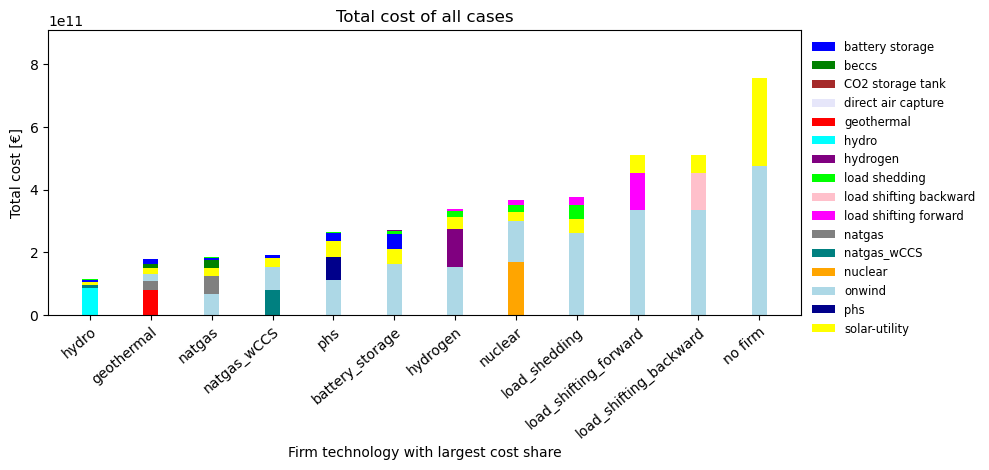

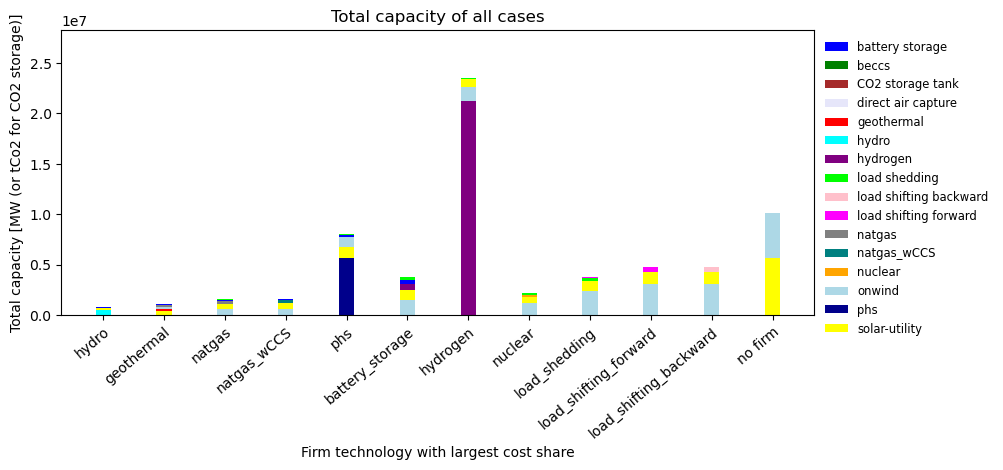

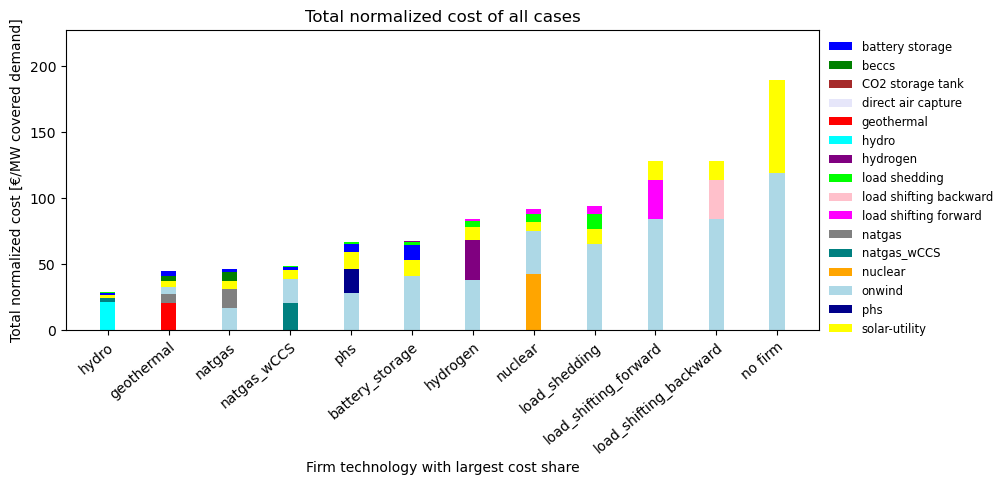

In [5]:
# Results directory
out_suff = ''
results_dir = 'output_data/all_firm_case'+out_suff

# Get color map
all_comp = read_component_results(results_dir, 'all_firm_all.pickle').index
color_dict = get_colors(sorted(all_comp, key=lambda x: x.lower()))


# Plot
costs = plot_results(results_dir, color_dict, 'cost', outfile_suffix=out_suff)
capacities = plot_results(results_dir, color_dict, 'capacity', outfile_suffix=out_suff)
total_demand = abs(get_demand(results_dir, 'all_firm_all.pickle'))


system_costs = [{} for i in range(len(costs))]
for i,case in enumerate(costs):
    for comp in case:
        system_costs[i][comp] = case[comp]/total_demand

plot_results(results_dir, color_dict, 'normalized cost', outfile_suffix=out_suff, pass_results=['system_cost [€/MWh]', system_costs])